In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings('ignore')

In [29]:
print('Importing data...')
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

Importing data...


# <a id=1 > 1. Processing test and train dataset </a>

In [30]:
target = train['TARGET']
del train['TARGET']

In [31]:
data = pd.concat([train,test])

In [32]:
data.shape, train.shape, test.shape

((356255, 121), (307511, 121), (48744, 121))

In [33]:
docs = [col for col in data.columns if 'FLAG_DOC' in col]
# Flag_document features - count and kurtosis
data['DOCUMENT_COUNT'] = data[docs].sum(axis=1)
data['NEW_DOC_KURT'] = data[docs].kurtosis(axis=1)  #long tails

In [34]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [35]:
# Categorical age - based on target=1 plot
data['AGE_RANGE'] = data['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

In [36]:
# New features based on External sources
data['EXT_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['EXT_SOURCES_WEIGHTED'] = data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 1 + data.EXT_SOURCE_3 * 3
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        data[feature_name] = eval('np.{}'.format(function_name))(
            data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [37]:
# Credit ratios
data['CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']

In [38]:
# Income ratios
data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['INCOME_TO_EMPLOYED_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_EMPLOYED']
data['INCOME_TO_BIRTH_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_BIRTH']
data['INCOME_TO_CREDIT_RATION'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']

In [39]:
# Time ratios
data['EMPLOYED_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['ID_TO_BIRTH_RATIO'] = data['DAYS_ID_PUBLISH'] / data['DAYS_BIRTH']
data['CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['CAR_TO_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
data['PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

In [40]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [41]:
# Groupby: Statistics for applications in the same group
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
data = do_median(data, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
data = do_std(data, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
data = do_mean(data, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
data = do_std(data, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
data = do_mean(data, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
data = do_std(data, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
data = do_mean(data, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
data = do_mean(data, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
data = do_std(data, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

In [42]:
# one-hot encoding
categorical_features = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_features)

In [43]:
data.shape

(356255, 277)

In [45]:
#Pre-processing previous_application
print('Pre-processing previous_application...')
prev = pd.read_csv('previous_application.csv')
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['COUNT_PREV_APP'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

Pre-processing previous_application...


In [46]:
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

In [47]:
data.shape

(356255, 440)

In [48]:
train = data.iloc[:train.shape[0],:]
test = data.iloc[train.shape[0]:,]

In [49]:
data.shape, train.shape, test.shape

((356255, 440), (307511, 440), (48744, 440))

In [50]:
del train['SK_ID_CURR']
del test['SK_ID_CURR']

In [51]:
train_x, valid_x, train_y, valid_y = train_test_split(train, target, test_size=0.2, shuffle=True)

In [52]:
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [53]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

In [54]:
#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.745384
[20]	valid_0's auc: 0.750835
[30]	valid_0's auc: 0.755446
[40]	valid_0's auc: 0.759018
[50]	valid_0's auc: 0.762153
[60]	valid_0's auc: 0.76511
[70]	valid_0's auc: 0.767159
[80]	valid_0's auc: 0.768675
[90]	valid_0's auc: 0.770228
[100]	valid_0's auc: 0.771386
[110]	valid_0's auc: 0.772085
[120]	valid_0's auc: 0.772836
[130]	valid_0's auc: 0.77329
[140]	valid_0's auc: 0.773736
[150]	valid_0's auc: 0.774244
[160]	valid_0's auc: 0.774637
[170]	valid_0's auc: 0.774934
[180]	valid_0's auc: 0.775205
[190]	valid_0's auc: 0.775412
[200]	valid_0's auc: 0.775656
[210]	valid_0's auc: 0.775918
[220]	valid_0's auc: 0.775999
[230]	valid_0's auc: 0.776021
[240]	valid_0's auc: 0.776368
[250]	valid_0's auc: 0.776568
[260]	valid_0's auc: 0.776508
[270]	valid_0's auc: 0.776562
[280]	valid_0's auc: 0.776533
Early stopping, best iteration is:
[249]	valid_0's auc: 0.776577


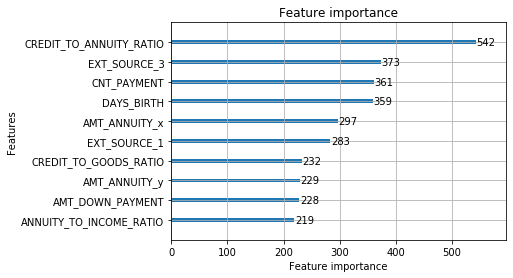

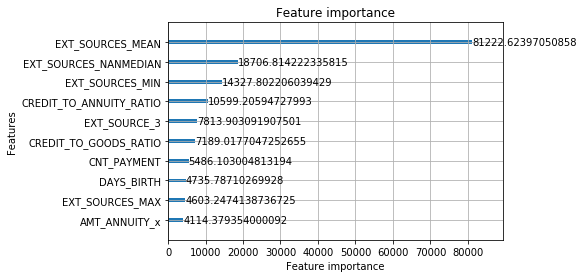

In [55]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=10, importance_type='split')
lgb.plot_importance(lgbm, max_num_features=10, importance_type='gain')

In [56]:
predictions_lgbm_prob = lgbm.predict(test)

In [57]:
lgbm_submission = pd.read_csv('sample_submission.csv')

In [58]:
lgbm_submission.TARGET = predictions_lgbm_prob

In [59]:
lgbm_submission.to_csv('lgbm_submission.csv', index=False) #score : 0.76012

data columns

In [24]:
column_info = pd.read_csv('HomeCredit_columns_description.csv', encoding = 'unicode_escape')

In [26]:
column_info[column_info['Table'] == 'previous_application.csv']

,Unnamed: 0,Table,Row,Description,Special
173,176,previous_application.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
174,177,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed
175,178,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN
177,180,previous_application.csv,AMT_APPLICATION,For how much credit did client ask on the prev...,NaN
178,181,previous_application.csv,AMT_CREDIT,Final credit amount on the previous applicatio...,NaN
179,182,previous_application.csv,AMT_DOWN_PAYMENT,Down payment on the previous application,NaN
180,183,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,NaN
181,184,previous_application.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...,NaN
182,185,previous_application.csv,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...,rounded
